# Oriented Object Detection

In [1]:
# Mount drive to import dataset
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [2]:
# Check nvcc version
!nvcc -V
# Check GCC version
!gcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2023 NVIDIA Corporation
Built on Tue_Aug_15_22:02:13_PDT_2023
Cuda compilation tools, release 12.2, V12.2.140
Build cuda_12.2.r12.2/compiler.33191640_0
gcc (Ubuntu 11.4.0-1ubuntu1~22.04) 11.4.0
Copyright (C) 2021 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.



In [3]:
# installing dependencies:
# install mmcv-full thus we could use CUDA operators
!pip install mmcv-full -f https://download.openmmlab.com/mmcv/dist/cu111/torch1.9.0/index.html

# Install mmdetection
!pip install mmdet

# Install mmrotate
!rm -rf mmrotate
!git clone https://github.com/open-mmlab/mmrotate.git
%cd mmrotate
!pip install -e .

# switch branch
!git checkout dev
!git branch -a

Looking in links: https://download.openmmlab.com/mmcv/dist/cu111/torch1.9.0/index.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 607.9/607.9 kB 11.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 254.7/254.7 kB 25.4 MB/s eta 0:00:00
  Created wheel for mmcv-full: filename=mmcv_full-1.7.2-cp310-cp310-linux_x86_64.whl size=27048662 sha256=689a997a2a5c4b624da387c7532e34673fb086fa8d54c40c6974f89c771dbb4f
  Stored in directory: /root/.cache/pip/wheels/4e/10/0a/78fbabe3d28cc25866432d4ecd6c9b124b8f0a6f546974bb7e
Successfully built mmcv-full
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 16.5 MB/s eta 0:00:00
Cloning into 'mmrotate'...
remote: Enumerating objects: 3853, done.
remote: Counting objects: 100% (1266/1266), done.
remote: Compressing objects: 100% (393/393), done.
remote: Total 3853 (delta 973), reused 899 (delta 873), pack-reused 2587
Receiving objects: 100% (3853/3853), 25.29 MiB | 16.45 MiB/s, done.
Resolving 

In [4]:
from mmcv import collect_env
collect_env()

No CUDA runtime is found, using CUDA_HOME='/usr/local/cuda'
/usr/local/lib/python3.10/dist-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2.0.0, in which it will remove components related to the training process and add a data transformation module. In addition, it will rename the package names mmcv to mmcv-lite and mmcv-full to mmcv. See https://github.com/open-mmlab/mmcv/blob/master/docs/en/compatibility.md for more details.
  warnings.warn(


{'sys.platform': 'linux',
 'Python': '3.10.12 (main, Nov 20 2023, 15:14:05) [GCC 11.4.0]',
 'CUDA available': False,
 'GCC': 'x86_64-linux-gnu-gcc (Ubuntu 11.4.0-1ubuntu1~22.04) 11.4.0',
 'PyTorch': '2.2.1+cu121',
 'PyTorch compiling details': 'PyTorch built with:\n  - GCC 9.3\n  - C++ Version: 201703\n  - Intel(R) oneAPI Math Kernel Library Version 2022.2-Product Build 20220804 for Intel(R) 64 architecture applications\n  - Intel(R) MKL-DNN v3.3.2 (Git Hash 2dc95a2ad0841e29db8b22fbccaf3e5da7992b01)\n  - OpenMP 201511 (a.k.a. OpenMP 4.5)\n  - LAPACK is enabled (usually provided by MKL)\n  - NNPACK is enabled\n  - CPU capability usage: AVX2\n  - Build settings: BLAS_INFO=mkl, BUILD_TYPE=Release, CUDA_VERSION=12.1, CUDNN_VERSION=8.9.2, CXX_COMPILER=/opt/rh/devtoolset-9/root/usr/bin/c++, CXX_FLAGS= -D_GLIBCXX_USE_CXX11_ABI=0 -fabi-version=11 -fvisibility-inlines-hidden -DUSE_PTHREADPOOL -DNDEBUG -DUSE_KINETO -DLIBKINETO_NOROCTRACER -DUSE_FBGEMM -DUSE_QNNPACK -DUSE_PYTORCH_QNNPACK -DUSE_XN

In [5]:
# Check Pytorch installation
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())

# Check MMRotate installation
import mmrotate
print(mmrotate.__version__)

# Check MMDetection installation
import mmdet
print(mmdet.__version__)

# Check mmcv installation
from mmcv.ops import get_compiling_cuda_version, get_compiler_version
print(get_compiling_cuda_version())
print(get_compiler_version())

2.2.1+cu121 False
0.3.4
2.28.2
not available
GCC 11.4


In [6]:
# We download the pre-trained checkpoints for inference and finetuning.
!mkdir checkpoints
!wget -c https://download.openmmlab.com/mmrotate/v0.1.0/oriented_rcnn/oriented_rcnn_r50_fpn_1x_dota_le90/oriented_rcnn_r50_fpn_1x_dota_le90-6d2b2ce0.pth \
      -O checkpoints/oriented_rcnn_r50_fpn_1x_dota_le90-6d2b2ce0.pth

--2024-04-09 06:06:04--  https://download.openmmlab.com/mmrotate/v0.1.0/oriented_rcnn/oriented_rcnn_r50_fpn_1x_dota_le90/oriented_rcnn_r50_fpn_1x_dota_le90-6d2b2ce0.pth
Resolving download.openmmlab.com (download.openmmlab.com)... 47.246.48.199, 47.246.48.200, 47.246.48.202, ...
Connecting to download.openmmlab.com (download.openmmlab.com)|47.246.48.199|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 165749436 (158M) [application/octet-stream]
Saving to: ‘checkpoints/oriented_rcnn_r50_fpn_1x_dota_le90-6d2b2ce0.pth’

checkpoints/oriente 100%[===================>] 158.07M  31.7MB/s    in 5.2s    

2024-04-09 06:06:10 (30.2 MB/s) - ‘checkpoints/oriented_rcnn_r50_fpn_1x_dota_le90-6d2b2ce0.pth’ saved [165749436/165749436]



In [7]:
import mmcv
from mmcv.runner import load_checkpoint

from mmdet.apis import inference_detector, show_result_pyplot
from mmrotate.models import build_detector

# Choose to use a config and initialize the detector
config = 'configs/oriented_rcnn/oriented_rcnn_r50_fpn_1x_dota_le90.py'
# Setup a checkpoint file to load
checkpoint = 'checkpoints/oriented_rcnn_r50_fpn_1x_dota_le90-6d2b2ce0.pth'

# Load the config
config = mmcv.Config.fromfile(config)
# Set pretrained to be None since we do not need pretrained model here
config.model.pretrained = None

# Initialize the detector
model = build_detector(config.model)

# Load checkpoint on CPU
checkpoint = load_checkpoint(model, checkpoint, map_location='cpu')

# Set the classes of models for inference
model.CLASSES = checkpoint['meta']['CLASSES']

# We need to set the model's cfg for inference
model.cfg = config

# Convert the model into evaluation mode
model.eval()

/usr/local/lib/python3.10/dist-packages/mmdet/models/dense_heads/anchor_head.py:116: UserWarning: DeprecationWarning: `num_anchors` is deprecated, for consistency or also use `num_base_priors` instead
  warnings.warn('DeprecationWarning: `num_anchors` is deprecated, '


load checkpoint from local path: checkpoints/oriented_rcnn_r50_fpn_1x_dota_le90-6d2b2ce0.pth


OrientedRCNN(
  (backbone): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): ResLayer(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
      

In [8]:
!unzip /content/drive/MyDrive/30.zip > /dev/null

In [9]:
# Check the directory structure of the dataset
# Install tree first
!apt-get -q install tree
!tree 30

Reading package lists...
Building dependency tree...
Reading state information...
The following NEW packages will be installed:
  tree
0 upgraded, 1 newly installed, 0 to remove and 45 not upgraded.
Need to get 47.9 kB of archives.
After this operation, 116 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tree amd64 2.0.2-1 [47.9 kB]
Fetched 47.9 kB in 0s (132 kB/s)
Selecting previously unselected package tree.
(Reading database ... 121753 files and directories currently installed.)
Preparing to unpack .../tree_2.0.2-1_amd64.deb ...
Unpacking tree (2.0.2-1) ...
Setting up tree (2.0.2-1) ...
Processing triggers for man-db (2.10.2-1) ...
30
├── images
│   ├── 10.png
│   ├── 11.png
│   ├── 12.png
│   ├── 13.png
│   ├── 14.png
│   ├── 15.png
│   ├── 16.png
│   ├── 17.png
│   ├── 18.png
│   ├── 19.png
│   ├── 1.png
│   ├── 20.png
│   ├── 21.png
│   ├── 22.png
│   ├── 23.png
│   ├── 24.png
│   ├── 25.png
│   ├── 26.png
│   ├── 27.png
│   ├

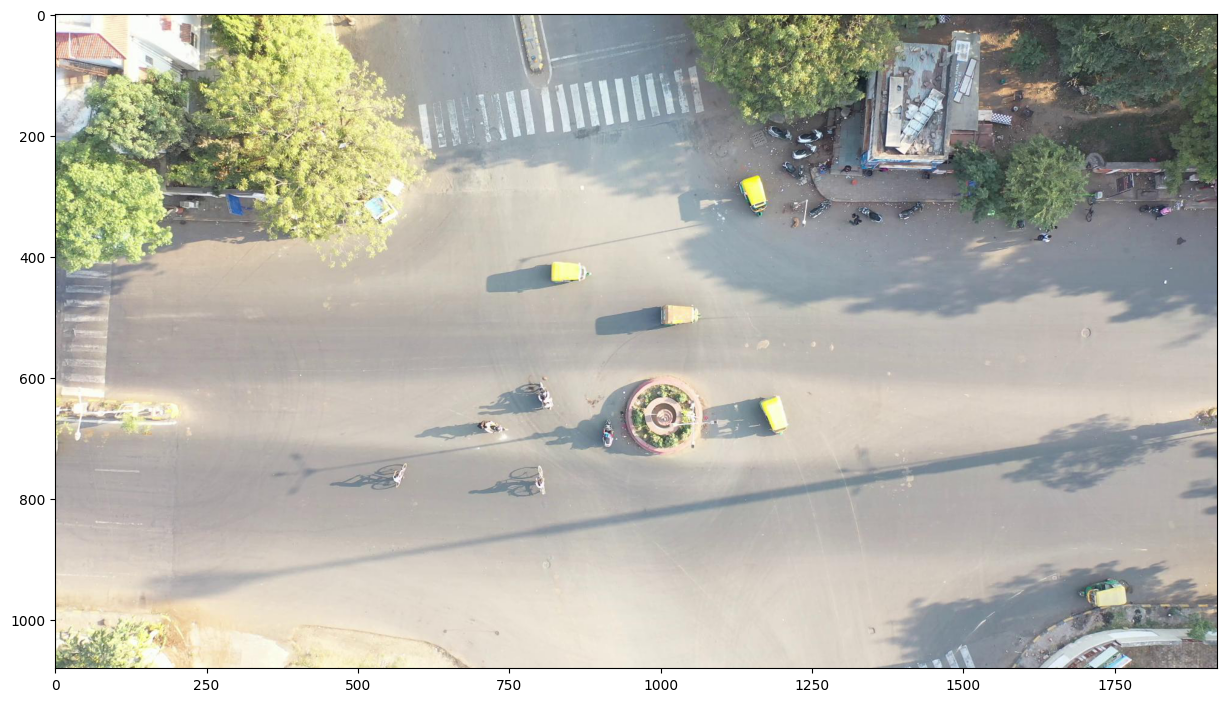

In [10]:
# Let's take a look at one of the dataset image
import matplotlib.pyplot as plt
img = mmcv.imread('30/images/1.png')
plt.figure(figsize=(15, 10))
plt.imshow(mmcv.bgr2rgb(img))
plt.show()

In [17]:
# Check the labels of images
!cat 30/txts/1.txt

1691 931 1691 980 1778 980 1778 931 awning-tricycle 1
1216 215 1216 240 1260 240 1260 215 motor 1
904 668 904 715 922 715 922 668 motor 1
1175 183 1175 208 1216 208 1216 183 motor 1
1244 306 1244 337 1282 337 1282 306 motor 1
1323 314 1323 345 1368 345 1368 314 motor 1
696 672 696 692 744 692 744 672 motor 1
1126 267 1126 333 1175 333 1175 267 awning-tricycle 1
999 479 999 515 1067 515 1067 479 awning-tricycle 1
1392 309 1392 339 1433 339 1433 309 motor 1
1163 630 1163 694 1210 694 1210 630 awning-tricycle 1
1200 242 1200 273 1237 273 1237 242 motor 1
818 409 818 444 884 444 884 409 awning-tricycle 1
1224 190 1224 214 1267 214 1267 190 motor 1


In [12]:
from mmrotate.datasets.builder import ROTATED_DATASETS
from mmrotate.datasets.dota import DOTADataset

@ROTATED_DATASETS.register_module(force=True)
class TinyDataset(DOTADataset):
    """AU Drone Dataset"""
    CLASSES = ('awning-tricycle', 'motor', 'people', 'truck', 'car', 'bicycle', 'van', 'tricycle')
# 'awning-tricycle', 'motor', 'people', 'pedestrian', 'car', 'truck', 'bicycle', 'van', 'tricycle', 'bus'

In [13]:
from mmcv import Config
cfg = Config.fromfile('./configs/oriented_rcnn/oriented_rcnn_r50_fpn_1x_dota_le90.py')

In [14]:
from mmdet.apis import set_random_seed

# Modify dataset type and path
cfg.dataset_type = 'TinyDataset'
cfg.data_root = '30/'

cfg.data.test.type = 'TinyDataset'
cfg.data.test.data_root = '30/'
cfg.data.test.ann_file = 'txts'
cfg.data.test.img_prefix = 'images'

cfg.data.train.type = 'TinyDataset'
cfg.data.train.data_root = '30/'
cfg.data.train.ann_file = 'txts'
cfg.data.train.img_prefix = 'images'

cfg.data.val.type = 'TinyDataset'
cfg.data.val.data_root = '30/'
cfg.data.val.ann_file = 'txts'
cfg.data.val.img_prefix = 'images'

# modify num classes of the model in box head
cfg.model.roi_head.bbox_head.num_classes = 8
# We can still use the pre-trained Mask RCNN model though we do not need to
# use the mask branch
cfg.load_from = 'checkpoints/oriented_rcnn_r50_fpn_1x_dota_le90-6d2b2ce0.pth'

# Set up working dir to save files and logs.
cfg.work_dir = './tutorial_exps'

cfg.optimizer.lr = 0.01
cfg.lr_config.warmup = None
cfg.runner.max_epochs = 5
cfg.log_config.interval = 1

# Change the evaluation metric since we use customized dataset.
cfg.evaluation.metric = 'mAP'
# We can set the evaluation interval to reduce the evaluation times
cfg.evaluation.interval = 1
# We can set the checkpoint saving interval to reduce the storage cost
cfg.checkpoint_config.interval = 1

# Set seed thus the results are more reproducible
cfg.seed = 0
set_random_seed(0, deterministic=False)
cfg.gpu_ids = range(1)

# We can also use tensorboard to log the training process
cfg.log_config.hooks = [
    dict(type='TextLoggerHook'),
    dict(type='TensorboardLoggerHook')]

cfg.device = 'cpu'

# We can initialize the logger for training and have a look
# at the final config used for training
print(f'Config:\n{cfg.pretty_text}')

Config:
dataset_type = 'TinyDataset'
data_root = '30/'
img_norm_cfg = dict(
    mean=[123.675, 116.28, 103.53], std=[58.395, 57.12, 57.375], to_rgb=True)
train_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(type='LoadAnnotations', with_bbox=True),
    dict(type='RResize', img_scale=(1024, 1024)),
    dict(
        type='RRandomFlip',
        flip_ratio=[0.25, 0.25, 0.25],
        direction=['horizontal', 'vertical', 'diagonal'],
        version='le90'),
    dict(
        type='Normalize',
        mean=[123.675, 116.28, 103.53],
        std=[58.395, 57.12, 57.375],
        to_rgb=True),
    dict(type='Pad', size_divisor=32),
    dict(type='DefaultFormatBundle'),
    dict(type='Collect', keys=['img', 'gt_bboxes', 'gt_labels'])
]
test_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(
        type='MultiScaleFlipAug',
        img_scale=(1024, 1024),
        flip=False,
        transforms=[
            dict(type='RResize'),
            dict(
                type='Normali

In [15]:
import os.path as osp

from mmdet.datasets import build_dataset
from mmdet.models import build_detector
from mmdet.apis import train_detector

# Build dataset
datasets = [build_dataset(cfg.data.train)]

# Build the detector
model = build_detector(
    cfg.model, train_cfg=cfg.get('train_cfg'), test_cfg=cfg.get('test_cfg'))
# Add an attribute for visualization convenience
model.CLASSES = datasets[0].CLASSES

# Create work_dir
mmcv.mkdir_or_exist(osp.abspath(cfg.work_dir))
train_detector(model, datasets, cfg, distributed=False, validate=True)

2024-04-09 06:06:32,688 - mmdet - INFO - Automatic scaling of learning rate (LR) has been disabled.
2024-04-09 06:06:32,704 - mmdet - INFO - load checkpoint from local path: checkpoints/oriented_rcnn_r50_fpn_1x_dota_le90-6d2b2ce0.pth
2024-04-09 06:06:32,929 - mmdet - WARNING - The model and loaded state dict do not match exactly

size mismatch for roi_head.bbox_head.fc_cls.weight: copying a param with shape torch.Size([16, 1024]) from checkpoint, the shape in current model is torch.Size([9, 1024]).
size mismatch for roi_head.bbox_head.fc_cls.bias: copying a param with shape torch.Size([16]) from checkpoint, the shape in current model is torch.Size([9]).
2024-04-09 06:06:32,940 - mmdet - INFO - Start running, host: root@12ea91fb5fd7, work_dir: /content/mmrotate/tutorial_exps
2024-04-09 06:06:32,941 - mmdet - INFO - Hooks will be executed in the following order:
before_run:
(VERY_HIGH   ) StepLrUpdaterHook                  
(NORMAL      ) CheckpointHook                     
(LOW         

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 30/30, 0.1 task/s, elapsed: 218s, ETA:     0s

2024-04-09 06:19:47,150 - mmdet - INFO - 
+-----------------+-----+------+--------+-------+
| class           | gts | dets | recall | ap    |
+-----------------+-----+------+--------+-------+
| awning-tricycle | 89  | 932  | 0.989  | 0.282 |
| motor           | 334 | 1094 | 0.599  | 0.315 |
| people          | 4   | 151  | 0.000  | 0.000 |
| truck           | 1   | 156  | 0.000  | 0.000 |
| car             | 177 | 1031 | 0.960  | 0.864 |
| bicycle         | 10  | 113  | 0.000  | 0.000 |
| van             | 6   | 203  | 0.333  | 0.004 |
| tricycle        | 4   | 183  | 0.000  | 0.000 |
+-----------------+-----+------+--------+-------+
| mAP             |     |      |        | 0.183 |
+-----------------+-----+------+--------+-------+
2024-04-09 06:19:47,268 - mmdet - INFO - Epoch(val) [1][30]	mAP: 0.1830
2024-04-09 06:20:29,558 - mmdet - INFO - Epoch [2][1/15]	lr: 1.000e-02, eta: 0:36:29, time: 42.276, data_time: 2.644, loss_rpn_cls: 0.0222, loss_rpn_bbox: 0.3663, loss_cls: 0.6039, acc: 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 30/30, 0.1 task/s, elapsed: 215s, ETA:     0s

2024-04-09 06:32:35,200 - mmdet - INFO - 
+-----------------+-----+------+--------+-------+
| class           | gts | dets | recall | ap    |
+-----------------+-----+------+--------+-------+
| awning-tricycle | 89  | 646  | 0.989  | 0.655 |
| motor           | 334 | 1106 | 0.674  | 0.478 |
| people          | 4   | 0    | 0.000  | 0.000 |
| truck           | 1   | 0    | 0.000  | 0.000 |
| car             | 177 | 703  | 0.960  | 0.909 |
| bicycle         | 10  | 0    | 0.000  | 0.000 |
| van             | 6   | 0    | 0.000  | 0.000 |
| tricycle        | 4   | 0    | 0.000  | 0.000 |
+-----------------+-----+------+--------+-------+
| mAP             |     |      |        | 0.255 |
+-----------------+-----+------+--------+-------+
2024-04-09 06:32:35,292 - mmdet - INFO - Epoch(val) [2][30]	mAP: 0.2552
2024-04-09 06:33:18,759 - mmdet - INFO - Epoch [3][1/15]	lr: 1.000e-02, eta: 0:26:46, time: 43.456, data_time: 2.665, loss_rpn_cls: 0.0143, loss_rpn_bbox: 0.3434, loss_cls: 0.3258, acc: 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 30/30, 0.1 task/s, elapsed: 216s, ETA:     0s

2024-04-09 06:45:41,505 - mmdet - INFO - 
+-----------------+-----+------+--------+-------+
| class           | gts | dets | recall | ap    |
+-----------------+-----+------+--------+-------+
| awning-tricycle | 89  | 372  | 0.989  | 0.785 |
| motor           | 334 | 800  | 0.695  | 0.521 |
| people          | 4   | 0    | 0.000  | 0.000 |
| truck           | 1   | 0    | 0.000  | 0.000 |
| car             | 177 | 329  | 0.966  | 0.909 |
| bicycle         | 10  | 0    | 0.000  | 0.000 |
| van             | 6   | 0    | 0.000  | 0.000 |
| tricycle        | 4   | 0    | 0.000  | 0.000 |
+-----------------+-----+------+--------+-------+
| mAP             |     |      |        | 0.277 |
+-----------------+-----+------+--------+-------+
2024-04-09 06:45:41,608 - mmdet - INFO - Epoch(val) [3][30]	mAP: 0.2768
2024-04-09 06:46:23,606 - mmdet - INFO - Epoch [4][1/15]	lr: 1.000e-02, eta: 0:17:42, time: 41.987, data_time: 2.633, loss_rpn_cls: 0.0071, loss_rpn_bbox: 0.1848, loss_cls: 0.3064, acc: 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 30/30, 0.1 task/s, elapsed: 218s, ETA:     0s

2024-04-09 06:58:51,248 - mmdet - INFO - 
+-----------------+-----+------+--------+-------+
| class           | gts | dets | recall | ap    |
+-----------------+-----+------+--------+-------+
| awning-tricycle | 89  | 296  | 0.989  | 0.860 |
| motor           | 334 | 654  | 0.737  | 0.640 |
| people          | 4   | 0    | 0.000  | 0.000 |
| truck           | 1   | 0    | 0.000  | 0.000 |
| car             | 177 | 293  | 1.000  | 0.990 |
| bicycle         | 10  | 0    | 0.000  | 0.000 |
| van             | 6   | 0    | 0.000  | 0.000 |
| tricycle        | 4   | 0    | 0.000  | 0.000 |
+-----------------+-----+------+--------+-------+
| mAP             |     |      |        | 0.311 |
+-----------------+-----+------+--------+-------+
2024-04-09 06:58:51,337 - mmdet - INFO - Epoch(val) [4][30]	mAP: 0.3112
2024-04-09 06:59:33,662 - mmdet - INFO - Epoch [5][1/15]	lr: 1.000e-02, eta: 0:08:33, time: 42.314, data_time: 2.626, loss_rpn_cls: 0.0200, loss_rpn_bbox: 0.3358, loss_cls: 0.1647, acc: 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 30/30, 0.1 task/s, elapsed: 216s, ETA:     0s

2024-04-09 07:11:49,931 - mmdet - INFO - 
+-----------------+-----+------+--------+-------+
| class           | gts | dets | recall | ap    |
+-----------------+-----+------+--------+-------+
| awning-tricycle | 89  | 193  | 0.989  | 0.832 |
| motor           | 334 | 674  | 0.713  | 0.643 |
| people          | 4   | 0    | 0.000  | 0.000 |
| truck           | 1   | 0    | 0.000  | 0.000 |
| car             | 177 | 318  | 1.000  | 0.998 |
| bicycle         | 10  | 0    | 0.000  | 0.000 |
| van             | 6   | 0    | 0.000  | 0.000 |
| tricycle        | 4   | 0    | 0.000  | 0.000 |
+-----------------+-----+------+--------+-------+
| mAP             |     |      |        | 0.309 |
+-----------------+-----+------+--------+-------+
2024-04-09 07:11:50,040 - mmdet - INFO - Epoch(val) [5][30]	mAP: 0.3092


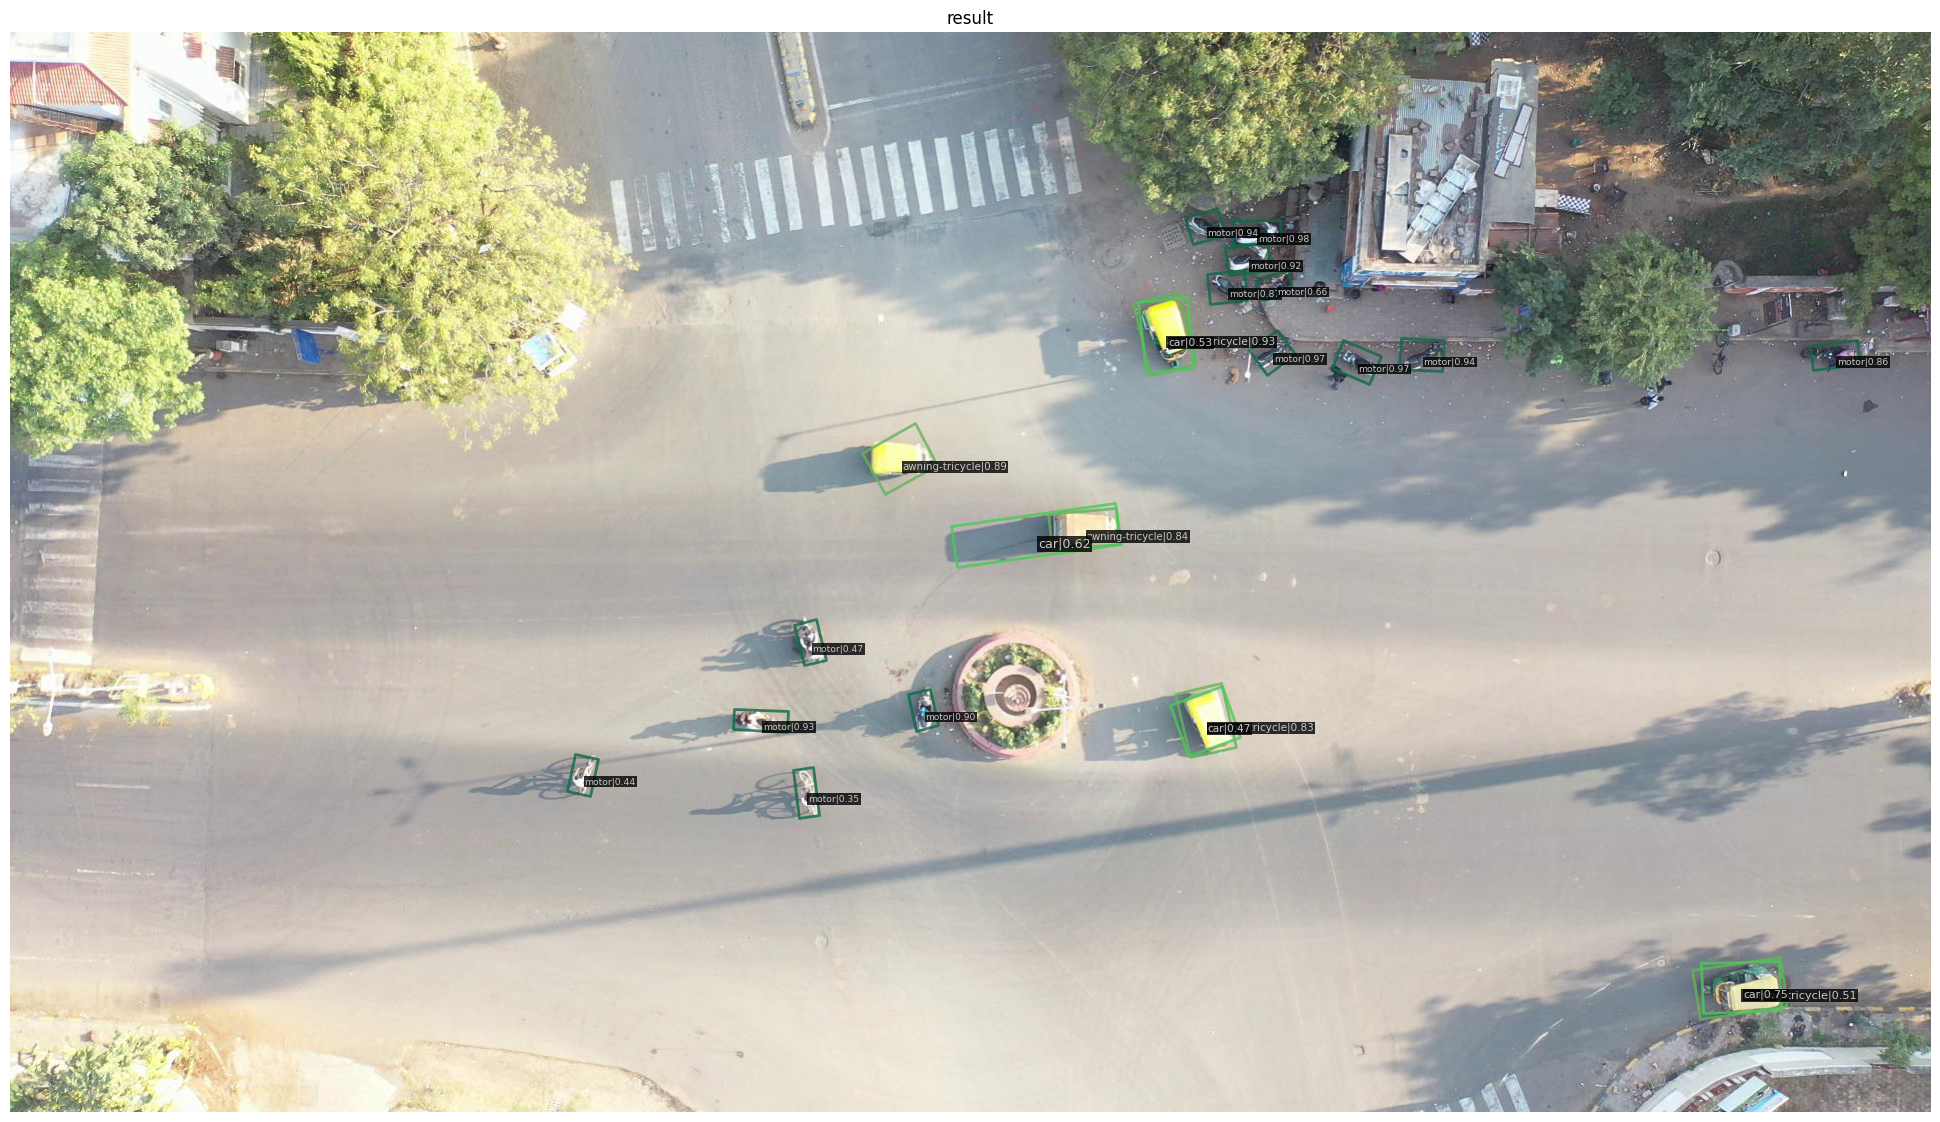

In [21]:
img = mmcv.imread('30/images/8.png')
model.cfg = cfg
result = inference_detector(model, img)
show_result_pyplot(model, img, result, score_thr=0.3)

Saving 669.png to 669.png


/usr/local/lib/python3.10/dist-packages/mmdet/models/dense_heads/anchor_head.py:123: UserWarning: DeprecationWarning: anchor_generator is deprecated, please use "prior_generator" instead
  warnings.warn('DeprecationWarning: anchor_generator is deprecated, '


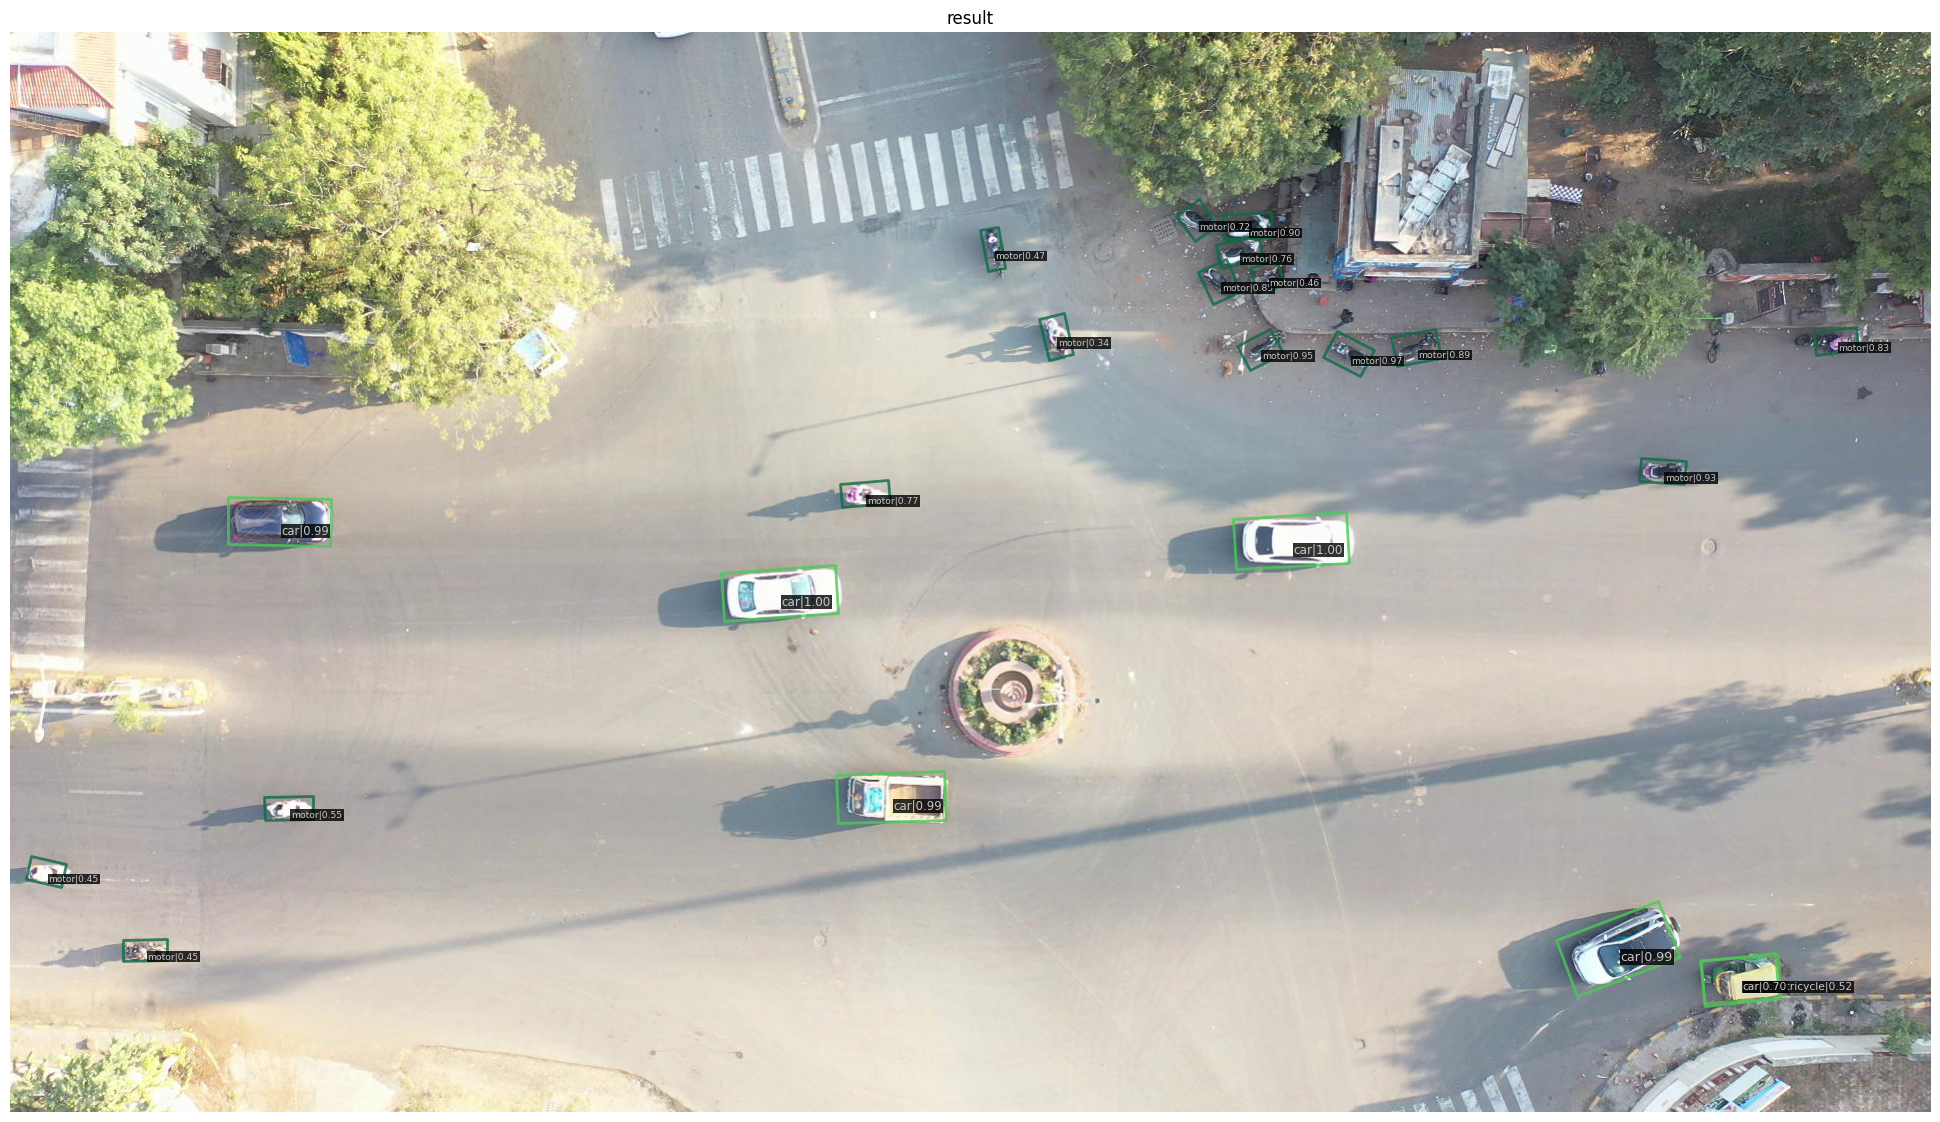

In [22]:
from google.colab import files

uploaded = files.upload()

# Get the uploaded image path
img_path = next(iter(uploaded))

img = mmcv.imread(img_path)
model.cfg = cfg
result = inference_detector(model, img)
show_result_pyplot(model, img, result, score_thr=0.3)